In [1]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

from skimage import io as skio

In [2]:
def randomCrop(img, mask, width=256, height=256, mode = []):
    assert img.shape[1] >= height
    assert img.shape[2] >= width
    assert img.shape[1] == mask.shape[1]
    assert img.shape[2] == mask.shape[2]

    # Set the seed for reproducibility across img and mask
    seed = random.randint(0, 2**32 - 1)
    random.seed(seed)
    torch.manual_seed(seed)
    
    if img.dtype == np.uint16 or img.dtype == np.uintc:
            img = img.astype(np.int32)
    if mask.dtype == np.uint16 or mask.dtype == np.uintc:
            mask = mask.astype(np.int32)


    # Convert numpy array to tensor and scale from uint16 to float range [0, 1]
    img = torch.from_numpy(img).float() / 65535
    mask = torch.from_numpy(mask).float() / 65535

    # Resize the images
    #img = TF.resize(img, [width, height])
    #mask = TF.resize(mask, [width, height])

    """
    # Crop
    i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(height, width))
    img = TF.crop(img, i, j, h, w)
    mask = TF.crop(mask, i, j, h, w)
    """
    if "af" in mode:
        random_degree = random.randint(10, 50)
        # Random affine transformation
        angle, translations, scale, shear = transforms.RandomAffine.get_params(
            
            degrees=(-1*random_degree, random_degree), translate=(0.1, 0.1), scale_ranges=(0.8, 1.2), shears=None, img_size=img.shape[1:]
        )
        img = TF.affine(img, angle=angle, translate=translations, scale=scale, shear=shear)
        mask = TF.affine(mask, angle=angle, translate=translations, scale=scale, shear=shear)
    elif "pd" in mode:
    
        # Photometric Distortion - simulate via ColorJitter
        brightness, contrast, saturation, hue = (0.3, 0.5, 0.5, 0.1)
        img = TF.adjust_brightness(img, brightness_factor=(1 + random.uniform(-brightness, -brightness)))
        img = TF.adjust_contrast(img, contrast_factor=(1 + random.uniform(-contrast, contrast)))
        img = TF.adjust_saturation(img, saturation_factor=(1 + random.uniform(-saturation, saturation)))
        img = TF.adjust_hue(img, hue_factor=random.uniform(-hue, hue))
    elif "flip" in mode:
        # Random horizontal and vertical flip
        if random.random() > 0.5:
            img = TF.hflip(img)
            mask = TF.hflip(mask)
        if random.random() > 0.5:
            img = TF.vflip(img)
            mask = TF.vflip(mask)
    
    # Convert back to numpy uint16
    img = (img * 65535).numpy().astype(np.uint16)
    mask = (mask * 65535).numpy().astype(np.uint16)

    return img, mask

(3, 256, 256)
(1, 256, 256)
(3, 256, 256)
(1, 256, 256)


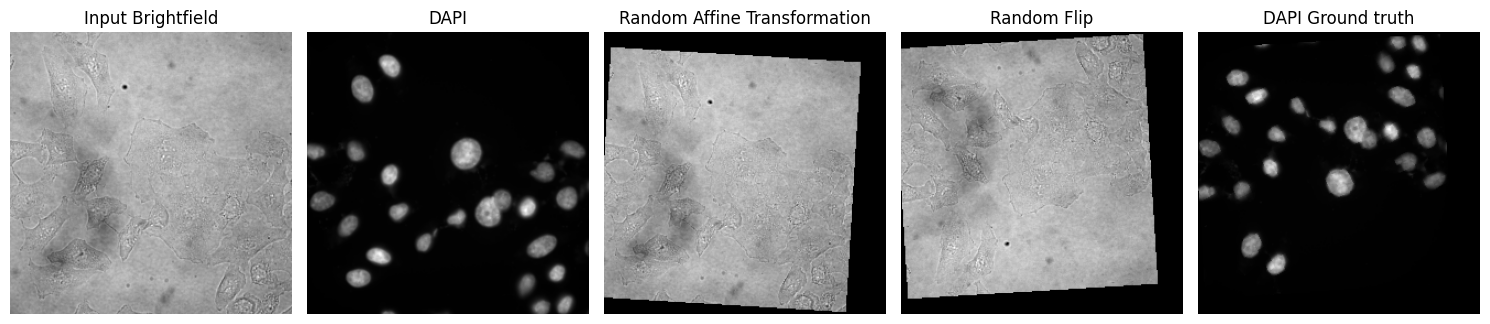

In [3]:
# image
path_dapi = r"E:\isl\data_set\tiff224_dapi_resized\1_dapi.png"
path_bf = r"E:\isl\data_set\tiff224_dapi_resized\1_bf_ch_1.tiff"
path_bf2 = r"E:\isl\data_set\tiff224_dapi_resized\1_bf_ch_2.tiff"
path_pc = r"E:\isl\data_set\tiff224_dapi_resized\1_pc.tiff"
image = skio.imread(path_bf)
image2 = skio.imread(path_bf2)
image3 = skio.imread(path_pc)
image4 = skio.imread(path_dapi)

new_image = np.stack((image, image2, image3), axis=-1)
new_image = np.transpose(new_image, (2, 0, 1))
print(new_image.shape)
mask = np.transpose(image4[:, :, np.newaxis], (2, 0,1))
print(mask.shape)
mode = ["af"]
im, ma = randomCrop(new_image,mask,mode=mode)

mode = ["flip"]
im2, ma2 = randomCrop(im,ma,mode=mode)

mode = ["pd"]
im3, ma3 = randomCrop(im2,ma2,mode=mode)
print(im.shape)
print(ma.shape)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

axes[0].imshow(new_image[0], cmap='gray')
#axes[0].imshow(new_image[0], cmap='gray')
axes[0].axis('off')  
axes[0].set_title('Input Brightfield')

axes[1].imshow(mask[0,:,:], cmap='gray')
axes[1].axis('off')  
axes[1].set_title('DAPI')


im[0][im[0] == 0] = np.min(new_image[0])
axes[2].imshow(im[0], cmap='gray')
axes[2].axis('off')  
axes[2].set_title('Random Affine Transformation')

im2[0][im2[0] == 0] = np.min(new_image[0])
axes[3].imshow(im2[0], cmap='gray')
axes[3].axis('off')  
axes[3].set_title('Random Flip')


#im3[0,255,250]= np.min(new_image[0])
#print(np.min(im3[0]),np.max(im3[0]))

#im3[0][im3[0] == 95] = np.min(new_image[0])
#axes[4].imshow(im3[0], cmap='gray')
#axes[4].axis('off')  
#axes[4].set_title('Photo Metric Distortion')

axes[4].imshow(ma2[0], cmap='gray')
axes[4].axis('off')  
axes[4].set_title('DAPI Ground truth')

plt.tight_layout()
plt.savefig(r'C:\Users\Marcel\OneDrive\Thesis\ISL\DAPI_augmented_dataset\Plots_augment/8.png')
plt.show()

### 